# Imports

In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.feature_extraction import DictVectorizer
from typing import Tuple, List
from tqdm.auto import tqdm

# Functions

In [24]:
def separate_target_from_features(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    target_name: str,
    log_transformation: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, np.array, np.array, np.array]:
    """
    From the three datasets (pandas dataframes, train, validation and test) containing all features and the
    target column, separate features and target to return three pandas dataframes containing only features and
    three numpy arrays containing target values. The target is selected according to the provided target_name.

    Args:
        train_df: pandas dataframe containing all training features and target values
        val_df: pandas dataframe containing all validation features and target values
        test_df: pandas dataframe containing all test features and target values

    Returns:
        train: pandas dataframe containing only features values for training dataset
        val: pandas dataframe containing only features values for validation dataset
        test: pandas dataframe containing only features values for test dataset
        y_train: numpy array containing train target values
        y_val: numpy array containing validation target values
        y_test: numpy array containing test target values
    """

    # Select the target values from original datasets
    y_train = train_df[target_name]
    y_val = val_df[target_name]
    y_test = test_df[target_name]

    # If the target value should be log transformed:
    if log_transformation:
        y_train = np.log1p(y_train)
        y_val = np.log1p(y_val)
        y_test = np.log1p(y_test)

    # Remove the target column from features dataset
    del train[target_name]
    del val[target_name]
    del test[target_name]

    return train, val, test, y_train, y_val, y_test

In [46]:
def prepare_feature_matrix_onehot(feature_df: pd.DataFrame) -> np.array:
    """
    From a pandas dataframe containing feature data (one feature per column), compute the feature matrix with one-hot encoding
    of the categorical columns.
    Categorical columns are one hot encoded using the DictVectorizer from sklearn.

    Args:
        feature_df: pandas dataframe containing feature data (one individual per row and one feature per column)

    Returns:
        feature_matrix: a numpy 2D array corresponding to the obtained feature matrix
    """

    feature_dicts = feature_df.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    feature_matrix = dv.fit_transform(feature_dicts)

    return feature_matrix

In [47]:
def prepare_train_val_test_feature_matrix_onehot(
    train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame
) -> Tuple[np.array, np.array, np.array]:
    """
    From a pandas dataframe containing feature data (one feature per column), compute the feature matrix with one-hot encoding
    of the categorical columns. The DictVectorizer is fit on the training data.
    Categorical columns are one hot encoded using the DictVectorizer from sklearn.

    Args:
        feature_df: pandas dataframe containing feature data (one individual per row and one feature per column)

    Returns:
        feature_matrix: a numpy 2D array corresponding to the obtained feature matrix
    """

    # First, create dictionaries from input dataframes obtained after splitting the data
    train_dicts = train_df.to_dict(orient="records")
    val_dicts = val_df.to_dict(orient="records")
    test_dicts = test_df.to_dict(orient="records")

    # Initiate the DictVectorizer and fit it on the train data dictionary
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    # Obtain the transformed features using the fitted DictVectorizer
    train_ohe = dv.transform(train_dicts)
    val_ohe = dv.transform(val_dicts)
    test_ohe = dv.transform(test_dicts)

    return train_ohe, val_ohe, test_ohe

In [60]:
def logistic_regression_metrics_feature_selection(
    feature_list: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_train: np.array,
    y_val: np.array,
    y_test: np.array,
) -> Tuple[float, float, float]:
    """
    Computes the accuracy of a logistic regression model trained on the provided training data, for training, validation
    and test data. The provided matrices should already be encoded for categorical variables.
    The logistic regression model has these parameters (fixed for this exercise): solver="liblinear", C=1.0, max_iter=1000, random_state=42.

    Args:
        feature_list: list of strings containing the features we want to keep in our feature matrices.
        train_df: pandas dataframe containing the training dataset values (features only)
        val_df: pandas dataframe containing the validation dataset values (features only)
        test_df: pandas dataframe containing the test dataset values (features only)
        y_train: numpy array containing the target values for the training dataset
        y_val: numpy array containing the target values for the validation dataset
        y_test: numpy array containing the target values for the test dataset

    Returns:
        score_train: float, the accuracy score obtained on the training dataset
        score_val: float, the accuracy score obtained on the validation dataset
        score_test: float, the accuracy score obtained on the test dataset
    """

    # Select the input features in our input dataframes
    train_selection = train_df[feature_list]
    val_selection = val_df[feature_list]
    test_selection = test_df[feature_list]

    # Create dictionaries from input dataframes obtained after splitting the data
    train_dicts = train_selection.to_dict(orient="records")
    val_dicts = val_selection.to_dict(orient="records")
    test_dicts = test_selection.to_dict(orient="records")

    # Initiate the DictVectorizer and fit it on the train data dictionary
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    # Obtain the transformed features using the fitted DictVectorizer
    train_ohe = dv.transform(train_dicts)
    val_ohe = dv.transform(val_dicts)
    test_ohe = dv.transform(test_dicts)

    # Train the model with these features:
    model = LogisticRegression(solver="liblinear", C=1, max_iter=1000)
    model.fit(train_ohe, y_train)

    # Accuracy on the train dataset
    score_train = model.score(train_ohe, y_train)
    print("Training Accuracy Score", round(score_train, 2))
    # Accuracy on the validation set
    score_val = model.score(val_ohe, y_val)
    print("Validation Accuracy Score", round(score_val, 2))
    # Accuracy on the test set
    score_test = model.score(test_ohe, y_test)
    print("Test Accuracy Score", round(score_test, 2))

    # Get predictions from the model
    y_pred_train = model.predict_proba(train_ohe)[:, 1]
    y_pred_val = model.predict_proba(val_ohe)[:, 1]
    y_pred_test = model.predict_proba(test_ohe)[:, 1]

    # ROC AUC on the train dataset
    train_auc = roc_auc_score(y_train, y_pred_train)
    val_auc = roc_auc_score(y_val, y_pred_val)
    test_auc = roc_auc_score(y_test, y_pred_test)

    print(f"The ROC AUC score obtained on the training data is {round(train_auc,4)}.")
    print(f"The ROC AUC score obtained on the validation data is {round(val_auc,4)}.")
    print(f"The ROC AUC score obtained on the test data is {round(test_auc,4)}.")

    return score_train, score_val, score_test

In [132]:
def plot_precision_recall_curve(y_true, y_pred, thresholds) -> pd.DataFrame:
    """
    From y_true values and y_pred values, plot the precision recall curve according to the array of thresholds.
    Args:
        y_true: np.array, true y values
        y_pred: np.array, predicted y values
        thresholds: np.array, the thresholds
    Returns:
        df_scores: pandas dataframe containing thresholds, tp, tn, fp, fn and precision and recall values as columns
    """

    # Instantiate scores lists
    scores = []

    for threshold in tqdm(thresholds):
        actual_positive = y_true == 1
        actual_negative = y_true == 0

        predict_positive = y_pred >= threshold
        predict_negative = y_pred < threshold

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((threshold, tp, fp, fn, tn))

    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)

    # Plot precision-recall curve
    plt.figure(figsize=(6, 4))
    plt.plot(df_scores["threshold"], df_scores["precision"], label="Precision")
    plt.plot(df_scores["threshold"], df_scores["recall"], label="Recall")

    # Find the intersection of the curves
    idx = np.argwhere(
        np.diff(
            np.sign(np.array(df_scores["precision"]) - np.array(df_scores["recall"]))
        )
    ).flatten()
    print(
        f"The precision and recall curves intersect at a threshold equal to {df_scores.loc[idx]['threshold']}."
    )

    plt.legend()
    plt.show()

    return df_scores

In [133]:
def logistic_regression_precision_recall_feature_selection(
    feature_list: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_train: np.array,
    y_val: np.array,
    y_test: np.array,
    thresholds: np.array,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Computes the accuracy of a logistic regression model trained on the provided training data, for training, validation
    and test data. The provided matrices should already be encoded for categorical variables.
    The logistic regression model has these parameters (fixed for this exercise): solver="liblinear", C=1.0, max_iter=1000, random_state=42.

    Args:
        feature_list: list of strings containing the features we want to keep in our feature matrices.
        train_df: pandas dataframe containing the training dataset values (features only)
        val_df: pandas dataframe containing the validation dataset values (features only)
        test_df: pandas dataframe containing the test dataset values (features only)
        y_train: numpy array containing the target values for the training dataset
        y_val: numpy array containing the target values for the validation dataset
        y_test: numpy array containing the target values for the test dataset
        threshold: float, the threshold above which the predicted class is equal to 1

    Returns:
        score_train: float, the accuracy score obtained on the training dataset
        score_val: float, the accuracy score obtained on the validation dataset
        score_test: float, the accuracy score obtained on the test dataset
    """

    # Select the input features in our input dataframes
    train_selection = train_df[feature_list]
    val_selection = val_df[feature_list]
    test_selection = test_df[feature_list]

    # Create dictionaries from input dataframes obtained after splitting the data
    train_dicts = train_selection.to_dict(orient="records")
    val_dicts = val_selection.to_dict(orient="records")
    test_dicts = test_selection.to_dict(orient="records")

    # Initiate the DictVectorizer and fit it on the train data dictionary
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    # Obtain the transformed features using the fitted DictVectorizer
    train_ohe = dv.transform(train_dicts)
    val_ohe = dv.transform(val_dicts)
    test_ohe = dv.transform(test_dicts)

    # Train the model with these features:
    model = LogisticRegression(solver="liblinear", C=1, max_iter=1000)
    model.fit(train_ohe, y_train)

    # Get predictions from the model
    y_pred_train = model.predict_proba(train_ohe)[:, 1]
    y_pred_val = model.predict_proba(val_ohe)[:, 1]
    y_pred_test = model.predict_proba(test_ohe)[:, 1]

    # Plot precision recall curves
    print("Precision and Recall for train dataset:\n")
    df_scores_train = plot_precision_recall_curve(y_train, y_pred_train, thresholds)
    print("Precision and Recall for validation dataset:\n")
    df_scores_val = plot_precision_recall_curve(y_val, y_pred_val, thresholds)
    print("Precision and Recall for test dataset:\n")
    df_scores_test = plot_precision_recall_curve(y_test, y_pred_test, thresholds)

    return df_scores_train, df_scores_val, df_scores_test

In [146]:
def compute_f1_score(y_true, y_pred, thresholds) -> pd.DataFrame:
    """
    From y_true values and y_pred values, plot the precision recall curve according to the array of thresholds.
    Args:
        y_true: np.array, true y values
        y_pred: np.array, predicted y values
        thresholds: np.array, the thresholds
    Returns:
        df_scores: pandas dataframe containing thresholds, tp, tn, fp, fn, precision, recall and f1-score values as columns
    """

    # Instantiate scores lists
    scores = []

    for threshold in tqdm(thresholds):
        actual_positive = y_true == 1
        actual_negative = y_true == 0

        predict_positive = y_pred >= threshold
        predict_negative = y_pred < threshold

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        scores.append((threshold, tp, fp, fn, tn))

    columns = ["threshold", "tp", "fp", "fn", "tn"]
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
    df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)

    # Compute the f1-score
    df_scores["f1_score"] = (
        2
        * (df_scores["precision"] * df_scores["recall"])
        / (df_scores["precision"] + df_scores["recall"])
    )

    # Get the threshold for which the F1 score is maximal
    max_threshold = df_scores[df_scores["f1_score"] == df_scores["f1_score"].max()][
        "threshold"
    ]

    # Plot the F1-score
    plt.plot(df_scores["threshold"], df_scores["f1_score"])
    plt.xticks(np.linspace(0, 1, 11))
    plt.show()

    print(f"The threshold for which the F1-score is maximal is : {max_threshold}.")

    return df_scores

In [142]:
def logistic_f1_score_feature_selection(
    feature_list: List[str],
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    y_train: np.array,
    y_val: np.array,
    y_test: np.array,
    thresholds: np.array,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Computes the accuracy of a logistic regression model trained on the provided training data, for training, validation
    and test data. The provided matrices should already be encoded for categorical variables.
    The logistic regression model has these parameters (fixed for this exercise): solver="liblinear", C=1.0, max_iter=1000, random_state=42.

    Args:
        feature_list: list of strings containing the features we want to keep in our feature matrices.
        train_df: pandas dataframe containing the training dataset values (features only)
        val_df: pandas dataframe containing the validation dataset values (features only)
        test_df: pandas dataframe containing the test dataset values (features only)
        y_train: numpy array containing the target values for the training dataset
        y_val: numpy array containing the target values for the validation dataset
        y_test: numpy array containing the target values for the test dataset
        threshold: float, the threshold above which the predicted class is equal to 1

    Returns:
        df_scores_train: pandas dataframe containing thresholds, tp, tn, fp, fn, precision, recall and f1-score values as columns for the training dataset
        df_scores_val: pandas dataframe containing thresholds, tp, tn, fp, fn, precision, recall and f1-score values as columns for the validation dataset
        df_scores_test: pandas dataframe containing thresholds, tp, tn, fp, fn, precision, recall and f1-score values as columns for the test dataset
    """

    # Select the input features in our input dataframes
    train_selection = train_df[feature_list]
    val_selection = val_df[feature_list]
    test_selection = test_df[feature_list]

    # Create dictionaries from input dataframes obtained after splitting the data
    train_dicts = train_selection.to_dict(orient="records")
    val_dicts = val_selection.to_dict(orient="records")
    test_dicts = test_selection.to_dict(orient="records")

    # Initiate the DictVectorizer and fit it on the train data dictionary
    dv = DictVectorizer(sparse=False)
    dv.fit(train_dicts)

    # Obtain the transformed features using the fitted DictVectorizer
    train_ohe = dv.transform(train_dicts)
    val_ohe = dv.transform(val_dicts)
    test_ohe = dv.transform(test_dicts)

    # Train the model with these features:
    model = LogisticRegression(solver="liblinear", C=1, max_iter=1000)
    model.fit(train_ohe, y_train)

    # Get predictions from the model
    y_pred_train = model.predict_proba(train_ohe)[:, 1]
    y_pred_val = model.predict_proba(val_ohe)[:, 1]
    y_pred_test = model.predict_proba(test_ohe)[:, 1]

    # Compute F1-scores
    print("Threshold corresponding to the maximum F1-score for the training data:")
    df_scores_train = compute_f1_score(y_train, y_pred_train, thresholds)
    print("Threshold corresponding to the maximum F1-score for the validation data:")
    df_scores_val = compute_f1_score(y_val, y_pred_val, thresholds)
    print("Threshold corresponding to the maximum F1-score for the test data:")
    df_scores_test = compute_f1_score(y_test, y_pred_test, thresholds)

    return df_scores_train, df_scores_val, df_scores_test

In [170]:
def train(feature_list, df_train, y_train, C=1.0):
    dicts = df_train[feature_list].to_dict(orient="records")

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver="liblinear", C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model


def predict(feature_list, df, dv, model):
    dicts = df[feature_list].to_dict(orient="records")

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

# Data loading

In [3]:
data = pd.read_csv("car_price.csv")

In [4]:
data.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


# Data preparation

In [7]:
columns_to_keep = [
    "Make",
    "Model",
    "Year",
    "Engine HP",
    "Engine Cylinders",
    "Transmission Type",
    "Vehicle Style",
    "highway MPG",
    "city mpg",
    "MSRP",
]

In [8]:
data = data[columns_to_keep]

In [9]:
data.head(5)

,Make,Model,Year,Engine HP,Engine Cylinders,Transmission Type,Vehicle Style,highway MPG,city mpg,MSRP
0,BMW,1 Series M,2011,335.0,6.0,MANUAL,Coupe,26,19,46135
1,BMW,1 Series,2011,300.0,6.0,MANUAL,Convertible,28,19,40650
2,BMW,1 Series,2011,300.0,6.0,MANUAL,Coupe,28,20,36350
3,BMW,1 Series,2011,230.0,6.0,MANUAL,Coupe,28,18,29450
4,BMW,1 Series,2011,230.0,6.0,MANUAL,Convertible,28,18,34500


Lowercase the column names and replace spaces with underscores:

In [11]:
data.columns = data.columns.str.replace(" ", "_").str.lower()

Fill the missing values with 0:

In [12]:
data = data.fillna(0)

Make the price binary (1 if above the average, 0 otherwise) - this will be our target variable above_average:

In [15]:
# Rename the msrp column to "price"
data = data.rename(columns={"msrp": "price"})

price_average = data["price"].mean()

In [16]:
price_average

40594.737032063116

In [17]:
# Add a new column according to this mean price
data["above_average"] = np.where(data["price"] > price_average, 1, 0)

In [28]:
# Here I remove the "price column"
del data["price"]

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1:

In [29]:
# First generate the full training dataset and the test dataset
full_train, test = train_test_split(data, test_size=0.2, random_state=1)

In [30]:
# Then separate the full training dataset into train and validation datasets. We have to adjust the proportions:
# we need 20% of the total number of rows from the 80% of values, which means we are looking for 0.25 proportion for the validation dataset
train, val = train_test_split(full_train, test_size=0.25, random_state=1)

In [31]:
train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'above_average'],
      dtype='object')

In [32]:
train, val, test, y_train, y_val, y_test = separate_target_from_features(
    train, val, test, "above_average"
)

In [33]:
train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [34]:
y_train

5727    1
5814    0
8450    0
2396    1
5494    0
       ..
5864    0
7924    0
4719    0
63      0
7918    0
Name: above_average, Length: 7148, dtype: int32

# Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

- For each numerical variable, use it as score and compute AUC with the above_average variable
- Use the training dataset for that
- If your AUC is < 0.5, invert this variable by putting "-" in front (e.g. -df_train['engine_hp'])


AUC can go below 0.5 if the variable is negatively correlated with the target variable. 

You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- engine_hp
- engine_cylinders
- highway_mpg
- city_mpg

In [35]:
numerical_variables = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg"]

In [41]:
train["engine_hp"]

5727    280.0
5814    300.0
8450    259.0
2396    280.0
5494    283.0
        ...  
5864    148.0
7924    325.0
4719    130.0
63      162.0
7918    240.0
Name: engine_hp, Length: 7148, dtype: float64

In [44]:
# For each numerical variable, use it as score and compute AUC with the above_average variable

for column in numerical_variables:
    column_auc = roc_auc_score(y_train, train[column])
    if column_auc < 0:
        column_auc = roc_auc_score(y_train, -train[column])
    print(
        f"The ROC AUC between above_average and {column} is equal to {round(column_auc,3)}."
    )

The ROC AUC between above_average and engine_hp is equal to 0.917.
The ROC AUC between above_average and engine_cylinders is equal to 0.766.
The ROC AUC between above_average and highway_mpg is equal to 0.367.
The ROC AUC between above_average and city_mpg is equal to 0.327.


The numerical variable "engine_hp" has the highest ROC AUC when compared to y_train.

# Question 2: Training the model

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

- LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

What's the AUC of this model on the validation dataset? (round to 3 digits)

In [61]:
score_train, score_val, score_test = logistic_regression_metrics_feature_selection(
    train.columns, train, val, test, y_train, y_val, y_test
)

Training Accuracy Score 0.95
Validation Accuracy Score 0.94
Test Accuracy Score 0.93
The ROC AUC score obtained on the training data is 0.987.
The ROC AUC score obtained on the validation data is 0.9802.
The ROC AUC score obtained on the test data is 0.9801.


The ROC AUC obtained on the validation data is very close to 0.979.

# Question 3 : Precision and Recall

Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

At which threshold precision and recall curves intersect?

In [63]:
number = 1 / 0.01
number

100.0

In [66]:
thresholds = np.linspace(0.0, 1.0, 101)

Precision and Recall for train dataset:



  0%|          | 0/101 [00:00<?, ?it/s]

The precision and recall curves intersect at a threshold equal to 45    0.45
99    0.99
Name: threshold, dtype: float64.


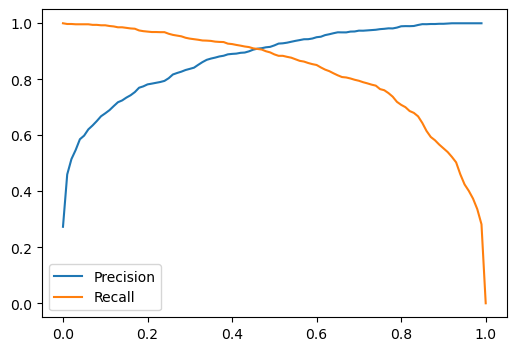

Precision and Recall for validation dataset:



  0%|          | 0/101 [00:00<?, ?it/s]

The precision and recall curves intersect at a threshold equal to 48    0.48
99    0.99
Name: threshold, dtype: float64.


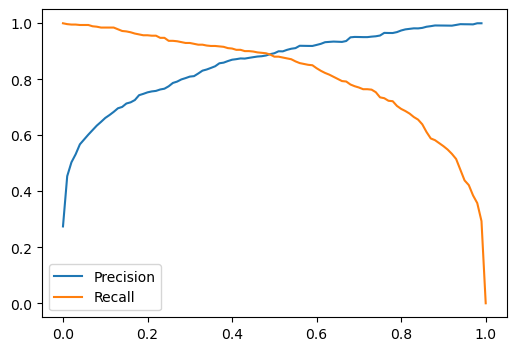

Precision and Recall for test dataset:



  0%|          | 0/101 [00:00<?, ?it/s]

The precision and recall curves intersect at a threshold equal to 43    0.43
44    0.44
99    0.99
Name: threshold, dtype: float64.


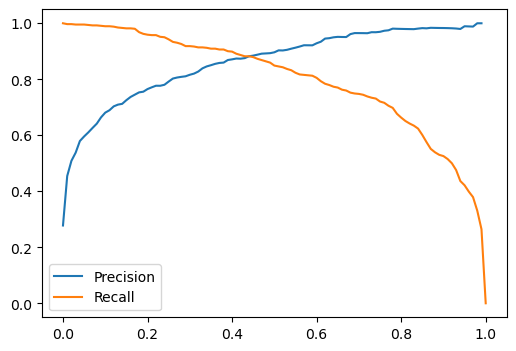

In [131]:
_, _, _ = logistic_regression_precision_recall_feature_selection(
    train.columns, train, val, test, y_train, y_val, y_test, thresholds
)

For the validation data, precision and recall curves intersect at a threshold equal to 0.48.

# Question 4: F1-score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

At which threshold F1 is maximal?

Threshold corresponding to the maximum F1-score for the training data:


  0%|          | 0/101 [00:00<?, ?it/s]

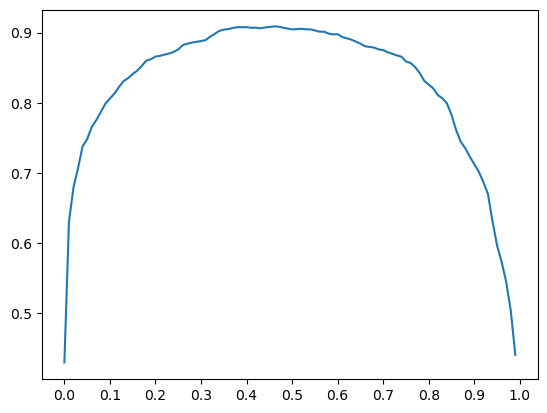

The threshold for which the F1-score is maximal is : 46    0.46
Name: threshold, dtype: float64.
Threshold corresponding to the maximum F1-score for the validation data:


  0%|          | 0/101 [00:00<?, ?it/s]

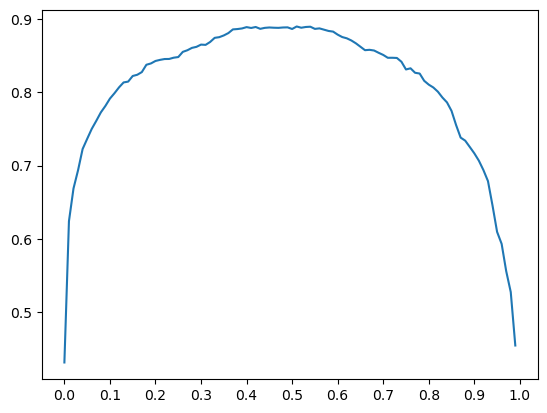

The threshold for which the F1-score is maximal is : 51    0.51
Name: threshold, dtype: float64.
Threshold corresponding to the maximum F1-score for the test data:


  0%|          | 0/101 [00:00<?, ?it/s]

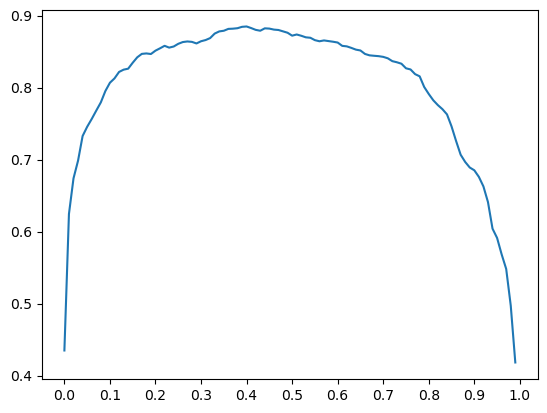

The threshold for which the F1-score is maximal is : 40    0.4
Name: threshold, dtype: float64.


In [147]:
_, _, _ = logistic_f1_score_feature_selection(
    train.columns, train, val, test, y_train, y_val, y_test, thresholds
)

For the validation data, the threshold for which the F1 score is maximal is very close to 0.52.

# Question 5 : 5-Fold CV

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

- KFold(n_splits=5, shuffle=True, random_state=1)

- Iterate over different folds of df_full_train
- Split the data into train and validation
- Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
- Use AUC to evaluate the model on validation


How large is standard deviation of the scores across different folds?

In [151]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [171]:
scores = []

for train_idx, val_idx in kfold.split(full_train):
    df_train = full_train.iloc[train_idx]
    df_val = full_train.iloc[val_idx]

    y_train = df_train["above_average"]
    y_val = df_val["above_average"]

    feature_list = df_train.columns.values.tolist()
    feature_list.remove("above_average")

    dv, model = train(feature_list, df_train, y_train, C=1.0)
    y_pred = predict(feature_list, df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("%.3f +- %.3f" % (np.mean(scores), np.std(scores)))

0.979 +- 0.002


The standard deviation across folds is very small, equal to around 0.003.

# Question 6 : Hyperparemeter Tuning

Now let's use 5-Fold cross-validation to find the best parameter C

- Iterate over the following C values: [0.01, 0.1, 0.5, 10]
- Initialize KFold with the same parameters as previously
- Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
- Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

- 0.01
- 0.1
- 0.5
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C.

In [173]:
for c_value in [0.01, 0.1, 0.5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(full_train):
        df_train = full_train.iloc[train_idx]
        df_val = full_train.iloc[val_idx]

        y_train = df_train["above_average"]
        y_val = df_val["above_average"]

        feature_list = df_train.columns.values.tolist()
        feature_list.remove("above_average")

        dv, model = train(feature_list, df_train, y_train, C=c_value)
        y_pred = predict(feature_list, df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print("C=%4s, %.3f +- %.3f" % (c_value, np.mean(scores), np.std(scores)))

C=0.01, 0.952 +- 0.002
C= 0.1, 0.972 +- 0.002
C= 0.5, 0.978 +- 0.003
C=  10, 0.984 +- 0.003


The highest mean is obtained with C=10.